In [1]:
import pandas as pd
from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from tqdm import tqdm_notebook

In [2]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt


Using TensorFlow backend.


In [3]:
try:
    from hyperopt import Trials, STATUS_OK, tpe, fmin, hp
except:
    !pip install hyperopt
    from hyperopt import Trials, STATUS_OK, tpe
import numpy as np
import pandas as pd
import os
import sys
import time
import pandas as pd
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import pickle
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Embedding
from keras.layers import LSTM
import keras
from keras.callbacks import Callback
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import CSVLogger
from sklearn.model_selection import GridSearchCV
# import psutil
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

import logging
import itertools as it

In [4]:
from keras.layers import Dropout

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [6]:
def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TimeSteps
    dim_0 = mat.shape[0] - TimeSteps
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TimeSteps, dim_1))
    y = np.zeros((dim_0,))
    
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TimeSteps+i]
        y[i] = mat[TimeSteps+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y


def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BatchSize
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [8]:
# # Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install pandas==0.24.2

In [9]:
data_dir = "../indices_quandl/"

files__ = pd.read_csv('../indices_details.csv')

sector_list_name =[]
sector_list =[]

In [10]:
for i in files__['Description'].unique():
    sector_list.append(list(files__['symbol'][files__['Description']==i]))
    sector_list_name.append(i)

In [11]:
commodity_list = list(files__['symbol'][files__['related_1st_pair']<6])

In [148]:
data.head()

,Date,Close
0,31-Jan-1980,11.37
1,29-Feb-1980,11.35
2,31-Mar-1980,11.59
3,30-Apr-1980,11.68
4,31-May-1980,11.66


In [233]:
data_assets_daily ={}
num_to_predict =2
for i in list([files__['files'][num_to_predict]]):
    print(i)
    name =i
    data = pd.read_csv(data_dir+list(files__['files'])[num_to_predict]+'.csv')
    data = data.dropna()
    data =data.rename(columns={"Vol.":"Volume","Price":"Close"})
    data["Volume"] = data["Volume"].astype(str)
    data["Volume"][data["Volume"]=="-"]="0K"
    data["Volume"][data["Volume"].str.contains("K").fillna(False)] = data["Volume"][data["Volume"].str.contains("K").fillna(False)].str.replace('K',"").apply(pd.to_numeric)*1000
    data["Volume"][data["Volume"].str.contains("M").fillna(False)] = data["Volume"][data["Volume"].str.contains("K").fillna(False)].str.replace('M',"").apply(pd.to_numeric)*1000000


US Wheat Futures (ZWN9)


In [316]:
params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs": 20,
    "lr": 0.01000,
    "time_steps": 60
}

BatchSize =40
TimeSteps = 60

In [317]:
df_ge = data[['Open','High','Low','Close','Volume']][data['Date']>='2015-01-01']#.tail(3*365).copy().reset_index(drop =True)

In [318]:
train_cols = list(df_ge.columns)
df_train, df_test = train_test_split(df_ge, train_size=0.8, test_size=0.2, shuffle=False)
#df_train = df_ge.head(df_train.Close.count()-20)
#df_test = df_ge.head(20)
print("Train and Test size", len(df_train), len(df_test))

Train and Test size 952 239


In [319]:
# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols].values)

In [320]:
column_to_predict = 3

In [321]:
x_t_act, y_t_act = build_timeseries(x_train, column_to_predict)
x_t = trim_dataset(x_t_act, BatchSize)
y_t = trim_dataset(y_t_act, BatchSize)
x_temp, y_temp = build_timeseries(x_test, column_to_predict)
x_val, x_test_t = np.split(trim_dataset(x_temp, BatchSize),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BatchSize),2)


length of time-series i/o (892, 60, 5) (892,)



length of time-series i/o (179, 60, 5) (179,)


In [322]:
lstm_model = Sequential()
lstm_model.add(LSTM(20, batch_input_shape=(BatchSize, TimeSteps, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,kernel_initializer='random_uniform'))
lstm_model.add(Dropout(0.7))
lstm_model.add(Dense(1,activation='relu'))
lstm_model.add(Dense(1,activation='sigmoid'))
optimizer = optimizers.RMSprop(lr=params["lr"])
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

In [323]:
#OUTPUT_PATH = "../indices_daily/"
#csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'your_log_name' + '.log'), append=True)


In [324]:
#os.path.join(OUTPUT_PATH, 'your_log_name' + '.log') , callbacks=[csv_logger]

In [325]:

history = lstm_model.fit(x_t, y_t, epochs=params["epochs"], verbose=1, batch_size=BatchSize,
                    shuffle=False, validation_data=(trim_dataset(x_val, BatchSize),
                    trim_dataset(y_val, BatchSize)))

Train on 880 samples, validate on 80 samples
Epoch 1/20
880/880 [==============================] - 4s 5ms/step - loss: 0.0480 - val_loss: 0.0183
Epoch 2/20
880/880 [==============================] - 1s 1ms/step - loss: 0.0414 - val_loss: 0.0220
Epoch 3/20
880/880 [==============================] - 1s 1ms/step - loss: 0.0364 - val_loss: 0.0122
Epoch 4/20
880/880 [==============================] - 1s 1ms/step - loss: 0.0316 - val_loss: 0.0095
Epoch 5/20
880/880 [==============================] - 1s 1ms/step - loss: 0.0266 - val_loss: 0.0092
Epoch 6/20
880/880 [==============================] - 1s 1ms/step - loss: 0.0231 - val_loss: 0.0069
Epoch 7/20
880/880 [==============================] - 1s 2ms/step - loss: 0.0201 - val_loss: 0.0154
Epoch 8/20
880/880 [==============================] - 1s 1ms/step - loss: 0.0180 - val_loss: 0.0063
Epoch 9/20
880/880 [==============================] - 1s 1ms/step - loss: 0.0167 - val_loss: 0.0078
Epoch 10/20
880/880 [==============================] - 

In [326]:
y_pred = lstm_model.predict(trim_dataset(x_test_t, BatchSize), batch_size=BatchSize)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BatchSize)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
# print(y_pred[0:15])
# print(y_test_t[0:15])

Error is 0.0037628495710587033 (80,) (80,)


In [327]:
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# print(y_pred_org[0:15])
# print(y_test_t_org[0:15])

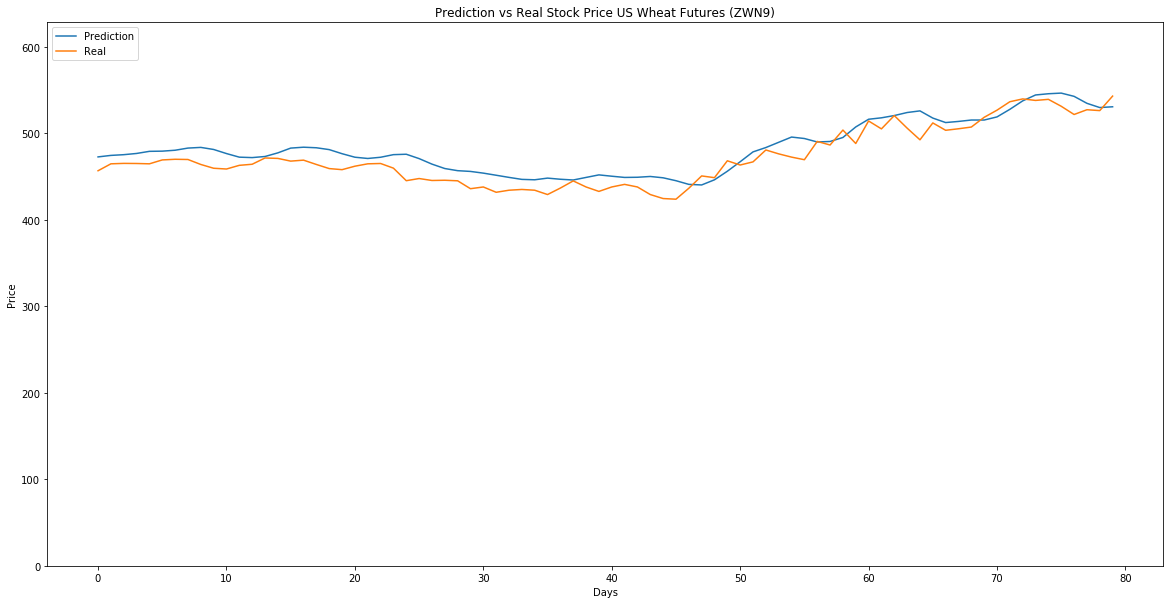

In [328]:
# Visualize the prediction
plt.figure(figsize=(20,10))
plt.plot(y_pred_org )
plt.plot(y_test_t_org )
plt.title('Prediction vs Real Stock Price '+name)
plt.ylabel('Price')
plt.xlabel('Days')
plt.ylim([0,y_pred_org.max()*1.15])
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()
#plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS'+str(BatchSize)+"_"+time.ctime()+'.png'))
#print_time("program completed ", stime)

In [277]:
print(i)

US Wheat Futures (ZWN9)
